# Figure S7: LARRY fate prediction (negative cross entropy)

Will be Fig. S10 in the revised manuscript

In [1]:
import larry
import pandas as pd
import ABCParse
import numpy as np
import pathlib
import glob
import pickle
import scdiffeq as sdq
import scdiffeq_analyses as sdq_an
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

In [2]:
F_obs = larry.tasks.fate_prediction.F_obs.copy()

### torch-pba

In [3]:
pba_dir = pathlib.Path("../../figure_2/results/fate_prediction/torch_pba/")

In [4]:
DataFrames = {}
for path in list(pba_dir.glob("PBA.F_hat.29SEPT2023*.csv")):
    seed = int(path.name.split("seed_")[1].split(".")[0])
    if seed <= 5:
        DataFrames[seed] = pd.read_csv(path, index_col = 0)
DataFrames = {key: DataFrames[key] for key in sorted(DataFrames)}

In [5]:
TorchPBAResults = {}
for seed, F_hat in DataFrames.items():
    _F_hat = F_hat.copy()
    _F_hat.index = _F_hat.index.astype(str)
    ce = sdq_an.metrics.cross_entropy(F_obs, _F_hat)
    TorchPBAResults[seed] = {"cross_entropy": ce}
torch_pba = pd.DataFrame(TorchPBAResults).T
torch_pba

valid_rows: 2081
valid_rows: 2081
valid_rows: 2081
valid_rows: 2081
valid_rows: 2081


,cross_entropy
0,2.998878
1,1.409061
3,1.681266
4,4.860762
5,3.845093


In [ ]:
3.0±1.5

In [6]:
torch_pba.mean(), torch_pba.std()

(cross_entropy    2.959012
 dtype: float64,
 cross_entropy    1.452443
 dtype: float64)

### TIGON

In [92]:
csv_path = "/Users/mvinyard/GitHub/scdiffeq-analyses/manuscript/figure_2/results/fate_prediction/TIGON/F_hat.TIGON.csv"

F_hat = pd.read_csv(csv_path, index_col = 0)
F_hat.index = F_hat.index.astype(str)
F_hat = F_hat.div(F_hat.sum(1), axis = 0).fillna(0)

In [100]:
adata = sdq.io.read_h5ad("/Users/mvinyard/Downloads/adata.Weinreb2020.in_vitro.gene_filtered.h5ad")

AnnData object with n_obs × n_vars = 130887 × 25289
    obs: 'Library', 'Cell barcode', 'Time point', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y', 'clone_idx', 'fate_observed', 't0_fated'
    var: 'gene_ids', 'hv_genes', 'use_genes'
    uns: 'fate_counts', 'time_occupance', 'h5ad_path'
    obsm: 'X_clone', 'cell_fate_df'


In [103]:
tigon_idx = F_hat.loc[F_hat.sum(1) > 0].index

In [113]:
fate_pred = F_hat.loc[tigon_idx].idxmax(1)

In [112]:
init_value = adata.obs.loc[tigon_idx]['Cell type annotation'].values

In [117]:
sum(init_value == fate_pred) / 105

0.9238095238095239

In [123]:
105/2081

0.05045651129264776

In [8]:
ce = sdq_an.metrics.cross_entropy(F_obs=F_obs, F_hat=F_hat, epsilon=1e-8)
tigon = pd.DataFrame({0: {"cross_entropy": ce}}).T
tigon

valid_rows: 105


,cross_entropy
0,3.450223


### PRESCIENT

In [9]:
pkl_path = "/Users/mvinyard/GitHub/_scdiffeq-analyses/manuscript_analyses/_figure2/task_2.fate_prediction/prescient_simout.pickle"
f = pd.read_pickle(pkl_path)
DataFrames = {"KEGG+": {}, "KEGG-": {}}
for key, val in f.items():
    seed = int(key[2].split("seed")[1])
    if "no" in key[-1]:
        DataFrames["KEGG-"][seed] = val
    else:
        DataFrames["KEGG+"][seed] = val

#### No weights

In [10]:
PRESCIENTResults = {}
for seed, F_hat in DataFrames['KEGG-'].items():
    _F_hat = F_hat.copy()
    _F_hat.index = F_obs.index
    _F_hat = _F_hat.drop("Undifferentiated", axis=1)
    ce = sdq_an.metrics.cross_entropy(F_obs=F_obs, F_hat=_F_hat)
    PRESCIENTResults[seed] = {"cross_entropy": ce}
prescient = pd.DataFrame(PRESCIENTResults).T
prescient

valid_rows: 1915
valid_rows: 1968
valid_rows: 1966
valid_rows: 1956
valid_rows: 1916


,cross_entropy
1,8.981964
2,10.101589
4,9.361535
0,9.283623
3,9.418569


In [11]:
prescient.mean(), prescient.std()

(cross_entropy    9.429456
 dtype: float64,
 cross_entropy    0.411707
 dtype: float64)

In [84]:
n_valid = 100 * np.array([1915, 1968, 1966, 1956, 1916]) / 2081
m, s = np.mean(n_valid), np.std(n_valid)
print(f"# valid: {m:.1f}±{s:.1f}")

# valid: 93.4±1.1


#### KEGG weights

In [12]:
PRESCIENTKEGGResults = {}
for seed, F_hat in DataFrames['KEGG+'].items():
    _F_hat = F_hat.copy()
    _F_hat.index = F_obs.index
    _F_hat = _F_hat.drop("Undifferentiated", axis=1)
    ce = sdq_an.metrics.cross_entropy(F_obs=F_obs, F_hat=_F_hat)
    PRESCIENTKEGGResults[seed] = {"cross_entropy": ce}
prescient_kegg = pd.DataFrame(PRESCIENTKEGGResults).T
prescient_kegg

valid_rows: 2018
valid_rows: 1988
valid_rows: 2027
valid_rows: 2036
valid_rows: 2005


,cross_entropy
3,8.021390
1,7.725916
0,8.317087
4,8.297305
2,7.997552


In [83]:
n_valid = 100 * np.array([2018, 1988, 2027, 2036, 2005]) / 2081
m, s = np.mean(n_valid), np.std(n_valid)
print(f"# valid: {m:.1f}±{s:.1f}")

# valid: 96.8±0.8


In [ ]:
8.1±0.2

In [13]:
prescient_kegg.mean(), prescient_kegg.std()

(cross_entropy    8.07185
 dtype: float64,
 cross_entropy    0.244289
 dtype: float64)

### scDiffEq

In [14]:
pkl_path = "/Users/mvinyard/GitHub/_scdiffeq-analyses/manuscript_analyses/_figure2/task_2.fate_prediction/scdiffeq_simout.pickle"
f = pd.read_pickle(pkl_path)
DataFrames = {"KEGG+": {}, "KEGG-": {}}
for key, val in f.items():
    seed = int(key[2].split("seed")[1])
    if "no" in key[-1]:
        DataFrames["KEGG-"][seed] = val
    else:
        DataFrames["KEGG+"][seed] = val

In [15]:
scDiffEqResults = {}
for seed, F_hat in DataFrames['KEGG-'].items():
    _F_hat = F_hat.copy()
    _F_hat.index = F_obs.index
    _F_hat = _F_hat.drop("Undifferentiated", axis=1)
    ce = sdq_an.metrics.cross_entropy(F_obs=F_obs, F_hat=_F_hat)
    scDiffEqResults[seed] = {"cross_entropy": ce}
scdiffeq = pd.DataFrame(scDiffEqResults).T

valid_rows: 2081
valid_rows: 2021
valid_rows: 2033
valid_rows: 2078
valid_rows: 2076


In [82]:
n_valid = 100 * np.array([2081, 2021, 2033, 2078, 2076]) / 2081
m, s = np.mean(n_valid), np.std(n_valid)
print(f"# valid: {m:.1f}±{s:.1f}")

# valid: 98.9±1.2


In [16]:
scDiffEqKEGGResults = {}
for seed, F_hat in DataFrames['KEGG+'].items():
    _F_hat = F_hat.copy()
    _F_hat.index = F_obs.index
    _F_hat = _F_hat.drop("Undifferentiated", axis=1)
    ce = sdq_an.metrics.cross_entropy(F_obs=F_obs, F_hat=_F_hat)
    scDiffEqKEGGResults[seed] = {"cross_entropy": ce}
scdiffeq_kegg = pd.DataFrame(scDiffEqKEGGResults).T

valid_rows: 2081
valid_rows: 2033
valid_rows: 2059
valid_rows: 2078
valid_rows: 2022


In [81]:
n_valid = 100 * np.array([2081, 2033, 2059, 2078, 2022]) / 2081
m, s = np.mean(n_valid), np.std(n_valid)
print(f"# valid: {m:.1f}±{s:.1f}")

# valid: 98.7±1.1


In [17]:
scdiffeq_kegg

,cross_entropy
3,3.348077
0,5.259191
4,5.631830
1,4.930747
2,5.354256


### sdq-xl

In [19]:
sdq_xl_results = {}
for csv_path in list(pathlib.Path("/Users/mvinyard/").glob("scdiffeq.xl*")):
    F_hat = pd.read_csv(csv_path, index_col = 0)
    seed = int(csv_path.name.split("seed_")[1].split(".")[0])
    if "Undifferentiated" in F_hat.columns:
        F_hat = F_hat.drop("Undifferentiated", axis=1)
    F_hat = F_hat.div(F_hat.sum(1), axis = 0).fillna(0)
    F_hat.index = F_hat.index.astype(str)
    sdq_xl_results[seed] = {"cross_entropy": sdq_an.metrics.cross_entropy(F_obs, F_hat)}
sdq_xl_results = pd.DataFrame(sdq_xl_results).T

valid_rows: 2075
valid_rows: 2080
valid_rows: 2064
valid_rows: 2064
valid_rows: 2075


In [85]:
n_valid = 100 * np.array([2075, 2080, 2064, 2064, 2075]) / 2081
m, s = np.mean(n_valid), np.std(n_valid)
print(f"# valid: {m:.1f}±{s:.1f}")

# valid: 99.5±0.3


In [ ]:
2.8±0.6

In [124]:
sdq_xl_results.mean()

cross_entropy    2.810075
dtype: float64

In [125]:
sdq_xl_results.std()

cross_entropy    0.571773
dtype: float64

In [20]:
sdq_xl_results

,cross_entropy
1,2.466671
2,3.815049
3,2.701247
4,2.620866
0,2.446544


In [21]:
def _read_process_F_hat(path, pickle=False, filter_nan=True):

    if pickle:
        F_hat = pd.read_pickle(path)[0]
    else:
        F_hat = pd.read_csv(path, index_col=0)
    F_hat_filt = F_hat.copy().drop("Undifferentiated", axis=1)
    F_hat_filt_norm = F_hat_filt.div(F_hat_filt.sum(1), axis=0).fillna(0)
    if filter_nan:
        F_hat_filt_norm = replace_undiff(F_hat_filt_norm)
    F_hat_filt_norm.index = F_obs.index  # F_hat_filt_norm.index.astype(str)
    return F_hat_filt_norm

def replace_undiff(F_hat_filt_norm):

    # create a temp vector to add undiff label
    undiff = np.zeros(len(F_hat_filt_norm))
    replace_idx = np.where(F_hat_filt_norm.sum(1) == 0)
    #     print(f"{replace_idx[0].shape[0]} non-fates")
    undiff[replace_idx] = 1

    # add to normalized matrix
    F_hat_filt_norm["Undifferentiated"] = undiff

    return F_hat_filt_norm

def compute_accuracy(F_obs, F_hat):
    y_true, y_pred = F_obs.idxmax(1).tolist(), F_hat.idxmax(1).tolist()
    return sklearn.metrics.accuracy_score(y_true, y_pred)


def get_organized_results(project_path):
    paths = list(project_path.glob("*/fate_prediction_metrics/*/F_hat.unfiltered.csv"))
    OrgResults = {}
    for path in paths:
        path_ = pathlib.Path(path)
        version = path_.parent.parent.parent.name
        if not version in OrgResults:
            OrgResults[version] = {}
        ckpt_name = path_.parent.name
        F_hat = _read_process_F_hat(path_, pickle=False)
        F_hat.index = F_hat.index.astype(str)
        acc = larry.tasks.fate_prediction.metrics.multi_idx_accuracy(F_obs, F_hat)
        train_acc = acc.loc["unique_train.all_fates"].iloc[0]
        test_acc = acc.loc["unique_test.all_fates"].iloc[0]
        OrgResults[version][ckpt_name] = {"train": train_acc, "test": test_acc}
        acc_ = compute_accuracy(F_obs, F_hat)
    #         print("| Accuracy: Train: {:.5f}, Test: {:.3f} |".format(train_acc, test_acc), version, ckpt_name)
    return OrgResults


def get_best_results(OrgResults):
    BestResults = {}
    for key, val in OrgResults.items():
        version_accuracy = pd.DataFrame(val).T
        best_ckpt = version_accuracy["train"].idxmax()
        best_test = version_accuracy.loc[best_ckpt]["test"]
        #         print(key, best_ckpt, best_test)
        #         best_.append()
        BestResults[key] = best_test

    return BestResults

In [22]:
# scDiffEq + KEGG + RVR=2.5
project_path = pathlib.Path(
    "/Users/mvinyard/GitHub/scdiffeq-analyses/manuscript/models/LARRY.fate_prediction/LightningSDE-FixedPotential-RegularizedVelocityRatio/"
)
project = sdq.io.Project(project_path)
versions = [
    getattr(project, attr) for attr in project.__dir__() if attr.startswith("version_")
]

best = {}
for version in versions:
    version_accuracy = sdq_an.parsers.VersionAccuracy(version)
    Vr = version.hparams["velocity_ratio_params"]["target"]
    if Vr == 2.5:
        accuracy = version_accuracy.best_test_from_train[["train", "test"]]
        best[version._NAME] = {"accuracy": accuracy, "version": version}


# org_results = get_organized_results(project_path)
# best_results = get_best_results(org_results)

In [23]:
DataFrames = {}
for key, val in best.items():
    ckpt_name = val['accuracy'].name
    epoch = int(ckpt_name.split(".")[0].split("_")[-1])
    F_hat_path = best[key]['version'].ckpts[epoch].path.parent.parent.joinpath(f"fate_prediction_metrics/{ckpt_name}/F_hat.unfiltered.csv")
    F_hat = pd.read_csv(F_hat_path, index_col = 0)
    DataFrames[key] = F_hat

In [32]:
scDiffEq_KEGG_RvR = {}
for key, F_hat in DataFrames.items():
    F_hat.index = F_hat.index.astype(str)
    F_hat.drop("Undifferentiated", axis=1)
    scDiffEq_KEGG_RvR[int(key.split("_")[1])] = {"cross_entropy": sdq_an.metrics.cross_entropy(F_obs, F_hat)}  
scdiffeq_rvr = pd.DataFrame(scDiffEq_KEGG_RvR).T

valid_rows: 2081
valid_rows: 2081
valid_rows: 2081
valid_rows: 2081
valid_rows: 2081


In [34]:
scdiffeq_rvr

,cross_entropy
31,4.022048
33,5.966025
35,3.535535
37,3.618564
39,4.115820


In [40]:
import cellplots as cp

In [86]:
colors = [
    "#9d0610",
    "#ffcc00",
    "#f27f34",
    "#eb5e28",
    "#00b4d8",
    "#0096c7",
    "#0077b6",
    "#214F87"
]

In [87]:
results = {
    "TorchPBA": torch_pba,
    "TIGON": tigon,
    "PRESCIENT": prescient,
    "PRESCIENT-KEGG": prescient_kegg,
    "scDiffEq": scdiffeq,
    "scDiffEq-KEGG": scdiffeq_kegg,
    "scDiffEq-KEGG-RvR": scdiffeq_rvr,
    "scDiffEq-KEGG-RvR-XL": sdq_xl_results
}
results = {key: ABCParse.as_list(val.values.flatten().tolist()) for key, val in results.items()}

In [88]:
import cellplots

In [91]:
tigon

,cross_entropy
0,3.450223


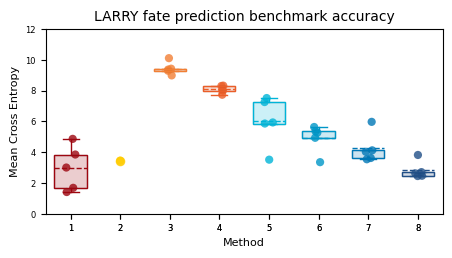

In [122]:
fig, axes = cellplots.plot(
    height=0.5,
    width=0.8,
    title=["LARRY fate prediction benchmark accuracy"],
    y_label=["Mean Cross Entropy"],
    x_label=["Method"],
)
bp = sdq_an.pl.boxplot(data=results, ax=axes[0], colors=colors, widths=0.65)
axes[0].set_ylim(0, 12)
plt.savefig("LARRY.fate_prediction_benchmark.mean_cross_entropy.svg", dpi=500)